In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

sber_data = pd.read_csv('data/sber_data.csv', sep=',', decimal='.')

In [2]:
sber_data['life_sq'].describe()

count    24088.000000
mean        34.403271
std         52.285733
min          0.000000
25%         20.000000
50%         30.000000
75%         43.000000
max       7478.000000
Name: life_sq, dtype: float64

In [3]:
# Найдём число квартир с нулевой жилой площадью:

sber_data[sber_data['life_sq'] == 0].shape[0]

45

In [4]:
# выведем здания с жилой площадью более 7 000 квадратных метров

sber_data[sber_data['life_sq'] > 7000]

,id,full_sq,life_sq,floor,sub_area,preschool_quota,preschool_education_centers_raion,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,...,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,theater_km,museum_km,ecology,mosque_count_1000,price_doc
13546,13549,79,7478.0,8.0,Poselenie Voskresenskoe,NaN,0,NaN,0,0,...,5.072389,1.210613,0.826052,1.582378,0.756119,21.472421,14.917332,no data,0,7705000


In [5]:
#  жилая площадь больше, чем суммарная?

outliers = sber_data[sber_data['life_sq'] > sber_data['full_sq']]
outliers.shape[0]

37

In [6]:
cleaned = sber_data.drop(sber_data[sber_data['life_sq'] > sber_data['full_sq']].index, axis=0)
cleaned = sber_data.drop(outliers.index, axis=0)
cleaned.shape[0]

30434

In [7]:
# давайте посмотрим на признак числа этажей (floor)

sber_data['floor'].describe()

count    30304.000000
mean         7.670803
std          5.319989
min          0.000000
25%          3.000000
50%          6.500000
75%         11.000000
max         77.000000
Name: floor, dtype: float64

In [8]:
sber_data[sber_data['floor'] > 50]

,id,full_sq,life_sq,floor,sub_area,preschool_quota,preschool_education_centers_raion,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,...,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,theater_km,museum_km,ecology,mosque_count_1000,price_doc
23584,23587,57,33.0,77.0,Lomonosovskoe,3091.0,5,8359.0,7,1,...,0.310557,0.731683,0.489763,0.86354,0.863266,2.920671,2.757058,satisfactory,0,13700000


Text(0.5, 1.0, 'Full Square Boxplot')

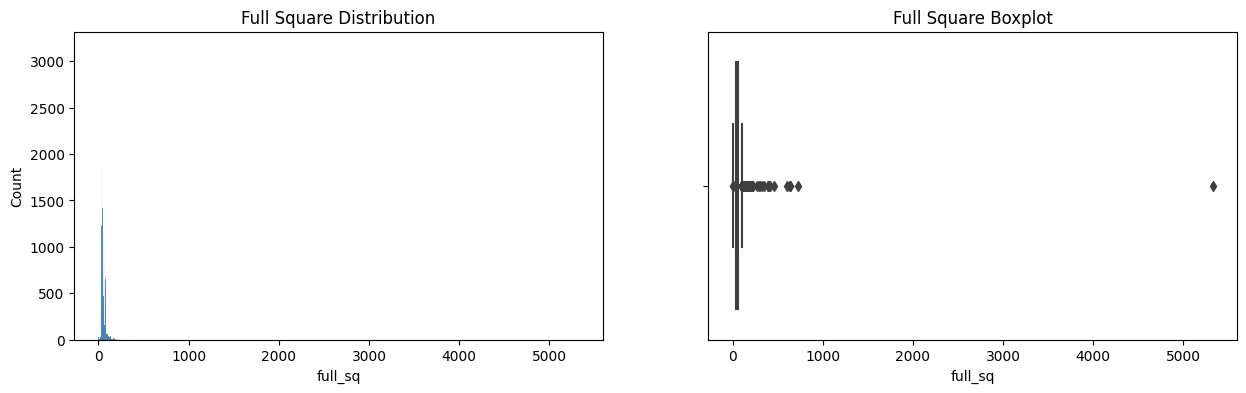

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(sber_data, x='full_sq', ax=axes[0])
histplot.set_title('Full Square Distribution')
boxplot = sns.boxplot(sber_data, x='full_sq', ax=axes[1])
boxplot.set_title('Full Square Boxplot')

In [18]:
# Метод межквартильного размаха (его еще называют методом Тьюки)

def outliers_iqr(data, feature):
    """
    Находит выбросы в данных, используя метод межквартильного размаха. 
    Классический метод модифицирован путем добавления:
    * возможности логарифмирования распредления
    * ручного управления количеством межквартильных размахов в обе стороны распределения
    Args:
        data (pandas.DataFrame): набор данных
        feature (str): имя признака, на основе которого происходит поиск выбросов
        left (float, optional): количество межквартильных размахов в левую сторону распределения. По умолчанию 1.5.
        right (float, optional): количество межквартильных размахов в правую сторону распределения. По умолчанию 1.5.
        log_scale (bool, optional): режим логарифмирования. По умолчанию False - логарифмирование не применяется.

    Returns:
        pandas.DataFrame: наблюдения, попавшие в разряд выбросов
        pandas.DataFrame: очищенные данные, из которых исключены выбросы
    """

    x = data[feature]
    quantile_1, quantile_3 = x.quantile(0.25), x.quantile(0.75)
    iqr = quantile_3 - quantile_1
    lower_bound = quantile_1 - (iqr * 1.5)
    upper_bound = quantile_3 + (iqr * 1.5)
    cleaned = data[(x <= upper_bound) & (x >= lower_bound)]
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    return cleaned, outliers

# Применим эту функцию к таблице sber_data и признаку full_sq, а также выведем размерности результатов:

cleaned, outliers = outliers_iqr(sber_data, 'full_sq')

print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 963
Результирующее число записей: 29508


Text(0.5, 1.0, 'Cleaned Full Square Boxplot')

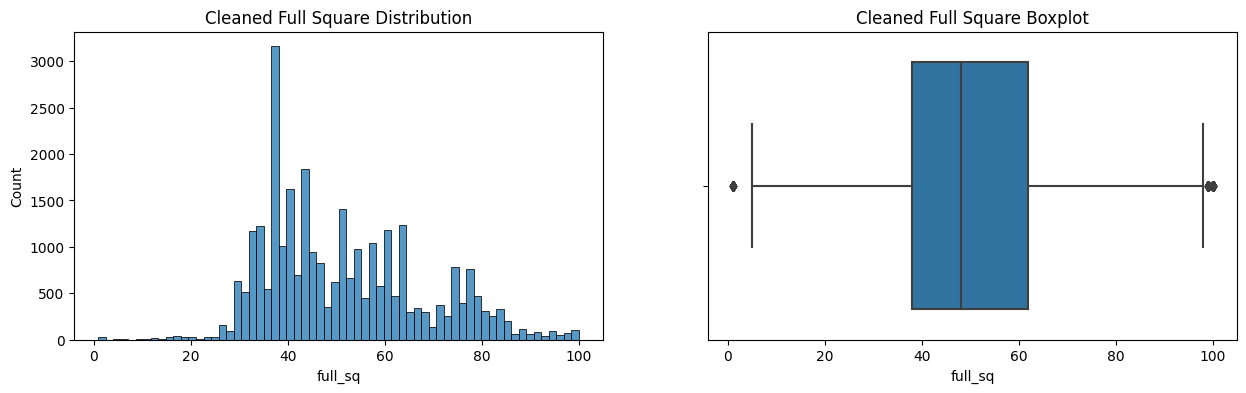

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='full_sq', ax=axes[0])
histplot.set_title('Cleaned Full Square Distribution')
boxplot = sns.boxplot(data=cleaned, x='full_sq', ax=axes[1])
boxplot.set_title('Cleaned Full Square Boxplot')

Число выбросов по методу Тьюки: 59
Результирующее число записей: 30412


Text(0.5, 1.0, 'Cleaned Full Square Boxplot')

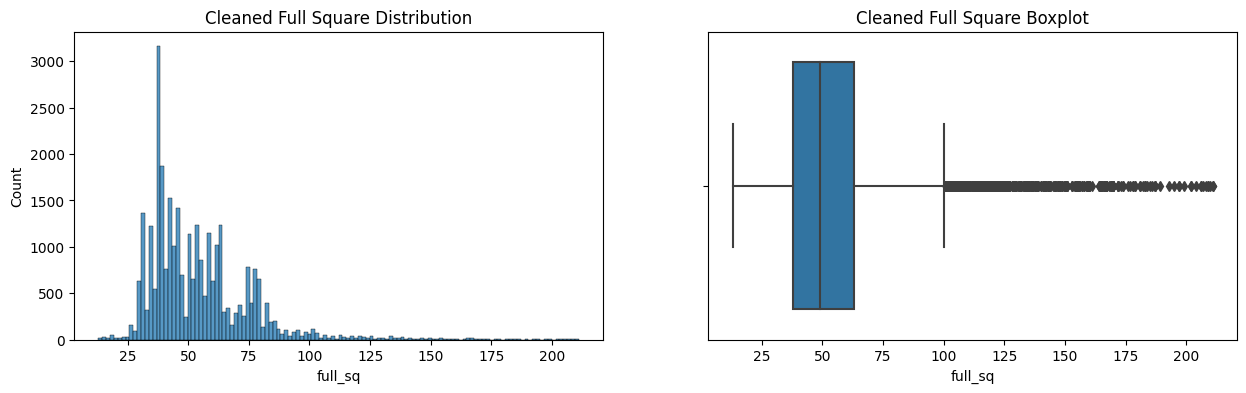

In [34]:
# 6.2

def outliers_iqr_mod(data, feature, left=1.5, right=1.5):
    x = data[feature]
    quantile_1, quantile_3 = x.quantile(0.25), x.quantile(0.75)
    iqr = quantile_3 - quantile_1
    lower = quantile_1 - (left * iqr)
    upper = quantile_3 + (right * iqr)
    cleaned = data[(data[feature] >= lower) & (data[feature] <= upper)]
    outliers = data[(data[feature] < lower) | (data[feature] > upper)]
    return cleaned, outliers

cleaned, outliers = outliers_iqr_mod(sber_data, 'full_sq', left=1, right=6)

print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='full_sq', ax=axes[0])
histplot.set_title('Cleaned Full Square Distribution')
boxplot = sns.boxplot(data=cleaned, x='full_sq', ax=axes[1])
boxplot.set_title('Cleaned Full Square Boxplot')

## МЕТОД Z-ОТКЛОНЕНИЙ (МЕТОД СИГМ)

Величина ассиметрии: -0.14263612203024953


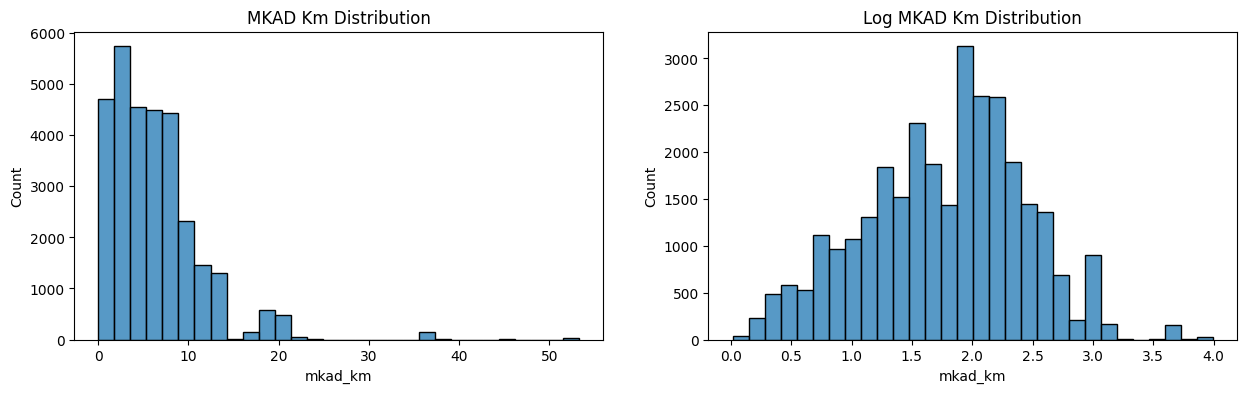

In [51]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

histogram = sns.histplot(data=sber_data['mkad_km'], bins=30, ax=axes[0])
histogram.set_title('MKAD Km Distribution')

mkad_km_log = np.log(sber_data['mkad_km'] + 1)
histogram_log = sns.histplot(data=mkad_km_log, bins=30, ax=axes[1])
histogram_log.set_title('Log MKAD Km Distribution')

# узнать величину ассиметрии

print('Величина ассиметрии:', mkad_km_log.skew())

In [53]:
def outliers_z_score(data, feature, log_scale=False):
    if log_scale:
        x = np.log(data[feature] + 1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x > upper_bound) | (x < lower_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

outliers, cleaned = outliers_z_score(sber_data, 'mkad_km', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')
    

Число выбросов по методу z-отклонения: 33
Результирующее число записей: 30438


In [57]:
# Давайте узнаем, в каких районах (sub_area) представлены эти квартиры:

outliers['sub_area'].unique()

array(['Poselenie Rogovskoe', 'Poselenie Kievskij'], dtype=object)

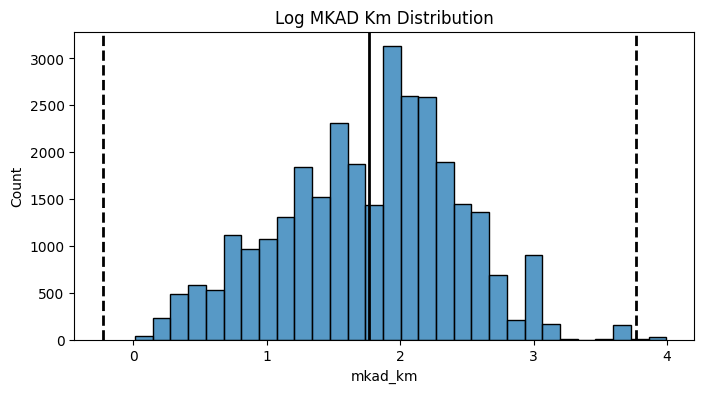

In [80]:
fig, axes = plt.subplots(1, 1, figsize=(8, 4))
log_mkad_km = np.log(sber_data['mkad_km'] + 1)
hist = sns.histplot(data=log_mkad_km, bins=30, ax=axes)
hist.set_title('Log MKAD Km Distribution')
hist.axvline(log_mkad_km.mean(), color = 'k', lw=2)
hist.axvline(log_mkad_km.mean() + 3 * log_mkad_km.std(), color='k', lw=2, ls='--')
hist.axvline(log_mkad_km.mean() - 3 * log_mkad_km.std(), color='k', ls='--', lw=2)

In [88]:
# 6.3 + 6.4

def outliers_z_score_mod(data, feature, log_scale=False, left=3, right=3):
    if log_scale:
        x = np.log(data[feature] + 1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    upper_bound = mu + right * sigma
    lower_bound = mu - left * sigma
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    return outliers, cleaned

outliers, cleaned = outliers_z_score_mod(sber_data, 'mkad_km', log_scale=True, left=3, right=3.5)

print(f'Результирующее число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число значений: {cleaned.shape[0]}')

Результирующее число выбросов по методу z-отклонения: 0
Результирующее число значений: 30471


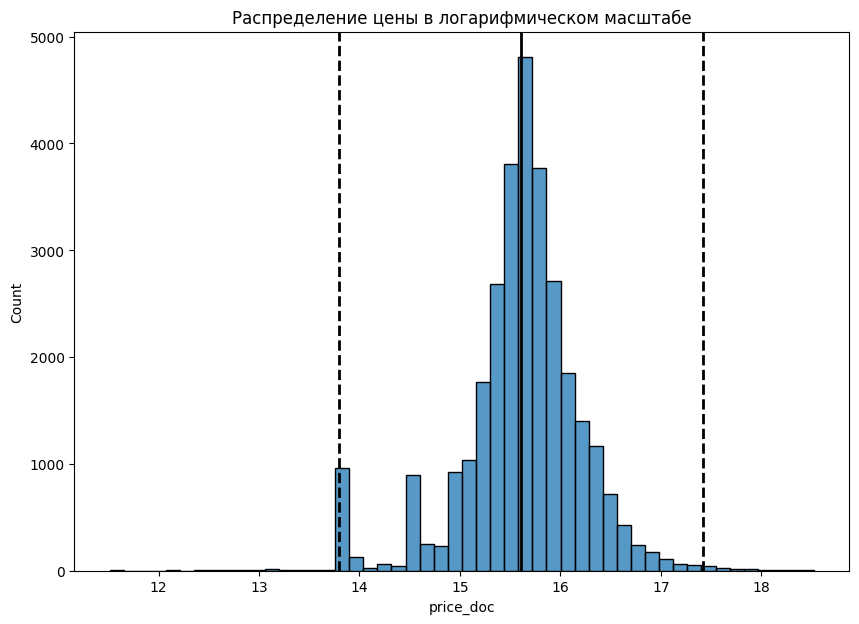

In [99]:
# 6.5

fig, axes = plt.subplots(1, 1, figsize=(10, 7))
p = np.log(sber_data['price_doc'] + 1)
hist = sns.histplot(data=p, bins=50, ax=axes)
hist.set_title('Распределение цены в логарифмическом масштабе')
hist.axvline(p.mean(), color='k', lw=2)
hist.axvline(p.mean() + 3 * p.std(), color='k', ls='--', lw=2)
hist.axvline(p.mean() - 3 * p.std(), color='k', ls='--', lw=2)


In [111]:
# 6.6

def outliers_z_score(data, feature, log_scale=False, left=3, right=3):
    if log_scale:
        x = np.log(data[feature] + 1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - (left * sigma)
    upper_bound = mu + (right * sigma)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

outliers, cleaned = outliers_z_score(sber_data, 'price_doc', log_scale=True, left=3.7, right=3.7)

print(f'Результирующее число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Результирующее число выбросов по методу z-отклонения: 52
Результирующее число записей: 30419


In [114]:
# 6.7

def outliers_iqr_mod(data, feature, log_scale, left=1.5, right=1.5):
    if log_scale:
        x = np.log(data[feature])
    else:
        x = data[feature]
    quantile_1, quantile_3 = x.quantile(0.25), x.quantile(0.75)
    iqr = quantile_3 - quantile_1
    lower_bound = quantile_1 - (left * iqr)
    upper_bound = quantile_3 + (right * iqr)
    outliers = data[(x > upper_bound) | (x < lower_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

outliers, cleaned = outliers_iqr_mod(sber_data, 'price_doc', log_scale=True, left=3, right=3)

print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')
    

Число выбросов по методу Тьюки: 92
Результирующее число записей: 30379
